In [1]:
import plotly.express as px
import polars as pl

from stocksense.config import config
from stocksense.database_handler import DatabaseHandler
from stocksense.model import XGBoostModel
from stocksense.pipeline import clean, engineer_features

features = config.model.features
target = config.model.target
date_col = config.model.date_col
aux_cols = ["tic", "datadate", "rdq"]

In [2]:
sp500_stocks = DatabaseHandler().fetch_sp500_stocks()

2024-11-24 11:31:44.019 | SUCCESS  | stocksense.database_handler.schema:create_tables:122 - Tables created successfully


In [3]:
data = engineer_features()
data = clean(data)
data.head()

2024-11-24 11:31:46.494 | INFO     | stocksense.pipeline.preprocess:engineer_features:20 - START processing stock data
2024-11-24 11:31:46.496 | SUCCESS  | stocksense.database_handler.schema:create_tables:122 - Tables created successfully
2024-11-24 11:31:50.073 | INFO     | stocksense.pipeline.preprocess:engineer_features:33 - START feature engineering
2024-11-24 11:31:50.977 | INFO     | stocksense.pipeline.preprocess:compute_vix_features:434 - START processing VIX data
2024-11-24 11:31:51.631 | SUCCESS  | stocksense.pipeline.preprocess:engineer_features:46 - END 169 features PROCESSED
2024-11-24 11:31:51.633 | INFO     | stocksense.pipeline.preprocess:clean:68 - START cleaning data
2024-11-24 11:31:51.752 | SUCCESS  | stocksense.pipeline.preprocess:clean:96 - 44097 rows retained after CLEANING


tic,datadate,rdq,saleq,cogsq,xsgaq,niq,ebitdaq,cshoq,actq,atq,cheq,rectq,invtq,ppentq,lctq,dlttq,ltq,req,seqq,oancfq,ivncfq,fincfq,dvq,capxq,icaptq,surprise_pct,tdq,stock_split,n_purch,val_purch,n_sales,val_sales,insider_balance,roa,roi,roe,…,dr_yoy,dr_2y,ltda_yoy,ltda_2y,pe_yoy,pe_2y,pb_yoy,pb_2y,ps_yoy,ps_2y,eps_yoy,eps_2y,ev_ebitda_yoy,ev_ebitda_2y,ltcr_yoy,itr_yoy,rtr_yoy,atr_yoy,f_score,f_score_gr1,f_score_gr4,index_freturn,freturn,adj_freturn,adj_fperf,fperf,sector_communication_services,sector_consumer_discretionary,sector_consumer_staples,sector_energy,sector_financials,sector_health_care,sector_industrials,sector_information_technology,sector_materials,sector_real_estate,sector_utilities
str,date,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,i8,u32,f64,u32,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,f64,f64,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
"""A""",2007-01-31,2007-02-15,1280.0,540.0,564.0,150.0,176.0,405.0,3749.0,7193.0,2090.0,671.0,648.0,775.0,1372.0,1500.0,3536.0,1705.0,3657.0,93.0,-93.0,-169.0,0.0,37.0,5157.0,0.011,2007-03-01,0,0,0.0,1,8.598,8.598,0.089114,0.029087,0.17528,…,2.640314,3.928494,11.580703,29.655039,282.560607,null,-7.754803,9.151709,-19.208201,null,-77.612898,null,-42.418432,null,131.460674,25.76978,22.719366,11.302357,7,1,null,-5.169725,-2.639948,2.529778,0,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2007-04-30,2007-05-14,1320.0,540.0,586.0,123.0,194.0,395.958,3791.0,7283.0,2050.0,718.0,650.0,777.0,1554.0,1500.0,3728.0,1881.0,3555.0,302.0,-36.0,-320.0,0.0,42.0,5055.0,-0.023,2007-06-01,0,0,0.0,3,2.695,2.695,0.089112,0.024332,0.18256,…,3.544885,9.453423,10.627489,30.16614,378.903526,null,16.399931,38.944827,-0.630294,null,-77.181676,null,-27.569721,null,7.883817,19.259654,24.025332,18.364403,7,0,null,-8.849601,-2.325005,6.524596,0,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2007-07-31,2007-08-14,1374.0,563.0,580.0,185.0,231.0,386.548,3281.0,7024.0,1486.0,738.0,674.0,787.0,1510.0,1500.0,3736.0,2069.0,3288.0,176.0,-258.0,-484.0,0.0,36.0,4788.0,-0.01,2007-09-01,0,0,0.0,2,5.747,5.747,0.086418,0.038638,0.184611,…,4.419175,14.878382,10.037016,36.525701,472.325667,null,25.872772,5.91443,3.996541,null,-79.822287,null,-14.222296,null,2000.0,18.769156,29.327755,22.359853,6,-1,null,-12.968883,-4.505501,8.463382,0,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2007-10-31,2007-11-15,1446.0,611.0,598.0,180.0,237.0,370.0,3671.0,7554.0,1826.0,735.0,643.0,801.0,1663.0,2087.0,4320.0,2580.0,3234.0,398.0,-69.0,-7.0,0.0,39.0,5321.0,0.022,2007-12-01,0,0,0.0,2,2.75,2.75,0.084459,0.033828,0.197279,…,13.590344,46.46352,35.725911,2000.0,456.222783,-60.359786,21.410892,-1.590112,-1.541225,-26.668893,-78.726207,165.240102,-5.153189,-45.143381,-32.276673,10.125696,14.20785,12.76951,5,-1,-1,-44.893122,-54.374817,-9.481695,0,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2008-01-31,2008-02-13,1393.0,580.0,617.0,120.0,196.0,368.0,5070.0,7459.0,3148.0,726.0,674.0,801.0,2674.0,626.0,4286.0,2657.0,3173.0,4.0,-295.0,-168.0,0.0,34.0,3799.0,0.021,2008-03-01,0,0,0.0,2,3.418,3.418,0.081512,0.031587,0.191617,…,16.887848,19.974054,-59.754945,-55.094284,-6.732989,256.802843,1.959688,-5.947085,-18.681512,-34.301331,4.388523,-76.630435,-23.738073,-56.087186,-228.366043,5.357524,1.528223,5.558859,6,1,-1,-44.756241,-54.68801,-9.931769,0,0,0,0,0,0,0,1,0,0,0,0,0


In [4]:
df = data.to_pandas()
df_standardized = (df[features] - df[features].mean()) / df[features].std()
corr = df_standardized.corrwith(df[target])
corr_df = pl.DataFrame({"Feature": corr.index, "Correlation": corr.values}).sort(
    "Correlation", descending=False
)

fig = px.bar(
    corr_df,
    x="Correlation",
    y="Feature",
    orientation="h",
    title="Feature Correlations with Target (fperf)",
    width=1000,
    height=1200,
)
fig.update_layout(yaxis={"tickfont": {"size": 10}}, showlegend=False, margin={"l": 200})
fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.show()

In [5]:
def get_scale(train):
    scale = round(
        len(train.filter(pl.col(target) == 0)) / len(train.filter(pl.col(target) == 1)), 2
    )
    print(f"Scale of training data (pos/neg): {scale}")
    return scale


data = data.select(["tic", date_col] + features + ["freturn", "adj_freturn", target])
data = data.filter((~pl.all_horizontal(pl.col(target).is_null())))
train = data.filter((pl.col("tdq").dt.year() >= 2007) & (pl.col("tdq").dt.year() <= 2021))
val = data.filter(
    (pl.col("tdq").dt.year() >= 2022)
    & (pl.col("tdq").dt.year() <= 2023)
    & (pl.col("tic").is_in(sp500_stocks))
)

scale = get_scale(train)

X_train = train.select(features).to_pandas()
y_train = train.select(target).to_pandas().values.ravel()
X_val = val.select(features).to_pandas()
y_val = val.select(target).to_pandas().values.ravel()

params = {
    "objective": "binary:logistic",
    "learning_rate": 0.1,
    "n_estimators": 200,
    "max_depth": 4,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 1,
    "colsample_bytree": 1,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "scale_pos_weight": scale,
    "eval_metric": "logloss",
    "nthread": -1,
    "seed": 100,
}

model = XGBoostModel(params)
model.train(X_train, y_train)

print(f"ROC-AUC: {model.roc_auc(X_val, y_val)}")
print(f"PR-AUC: {model.pr_auc(X_val, y_val)}")

baseline = float(len(val.filter(pl.col(target) == 1)) / len(val))

pr_auc = model.pr_auc(X_val, y_val)

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Scale of training data (pos/neg): 3.64
ROC-AUC: 0.576048775169909
PR-AUC: 0.23323734009224095
Baseline 0.15410747374922792, PR-AUC = 0.23323734009224095


In [6]:
y_proba = model.predict_proba(X_val)
val_subset = val.with_columns(pl.Series("proba", y_proba)).sort("proba", descending=True)
n = 10
top = val_subset.head(n)
bottom = val_subset.tail(n)

# Calculate average returns for top stocks
top_freturn = top.select(pl.col("freturn")).mean().item()
top_adj_freturn = top.select(pl.col("adj_freturn")).mean().item()

# Calculate average returns for bottom stocks
bottom_freturn = bottom.select(pl.col("freturn")).mean().item()
bottom_adj_freturn = bottom.select(pl.col("adj_freturn")).mean().item()

freturn = val_subset.select(pl.col("freturn")).mean().item()
adj_freturn = val_subset.select(pl.col("adj_freturn")).mean().item()

print(f"Average freturn: {freturn:.2f}%")
print(f"Average adj_freturn: {adj_freturn:.2f}%")

print(f"\nTop {n} stocks:")
print(f"Average freturn: {top_freturn:.2f}%")
print(f"Average adj_freturn: {top_adj_freturn:.2f}%")
print(f"\nBottom {n} stocks:")
print(f"Average freturn: {bottom_freturn:.2f}%")
print(f"Average adj_freturn: {bottom_adj_freturn:.2f}%")

Average freturn: 11.39%
Average adj_freturn: -3.10%

Top 10 stocks:
Average freturn: 58.98%
Average adj_freturn: 49.96%

Bottom 10 stocks:
Average freturn: 5.73%
Average adj_freturn: -19.82%


In [7]:
for date in ["2022-03-01", "2022-06-01", "2022-09-01", "2022-12-01", "2023-03-01", "2023-06-01"]:
    y_proba = model.predict_proba(X_val)
    val_subset = (
        val.with_columns(pl.Series("proba", y_proba))
        .filter(pl.col("tdq") == pl.lit(date).str.to_date())
        .sort("proba", descending=True)
    )
    n = 15
    top = val_subset.head(n)
    bottom = val_subset.tail(n)

    # Calculate average returns for top stocks
    top_freturn = top.select(pl.col("freturn")).mean().item()
    top_adj_freturn = top.select(pl.col("adj_freturn")).mean().item()

    # Calculate average returns for bottom stocks
    bottom_freturn = bottom.select(pl.col("freturn")).mean().item()
    bottom_adj_freturn = bottom.select(pl.col("adj_freturn")).mean().item()

    print(f"\nDATE {date}")
    print(f"\nTop {n} stocks:")
    print(f"Average freturn: {top_freturn:.2f}%")
    print(f"Average adj_freturn: {top_adj_freturn:.2f}%")
    print(f"\nBottom {n} stocks:")
    print(f"Average freturn: {bottom_freturn:.2f}%")
    print(f"Average adj_freturn: {bottom_adj_freturn:.2f}%")

    high_prob = val_subset.filter(pl.col("proba") > 0.6)
    n = len(high_prob)
    top = high_prob.head(n)

    # Calculate average returns for top stocks
    top_freturn = top.select(pl.col("freturn")).mean().item()
    top_adj_freturn = top.select(pl.col("adj_freturn")).mean().item()

    print(f"\nTop {n} stocks:")
    print(f"Average freturn: {top_freturn:.2f}%")
    print(f"Average adj_freturn: {top_adj_freturn:.2f}%")


DATE 2022-03-01

Top 15 stocks:
Average freturn: 8.04%
Average adj_freturn: 16.28%

Bottom 15 stocks:
Average freturn: -4.10%
Average adj_freturn: 4.14%

Top 1 stocks:
Average freturn: 8.20%
Average adj_freturn: 16.44%

DATE 2022-06-01

Top 15 stocks:
Average freturn: 20.49%
Average adj_freturn: 17.57%

Bottom 15 stocks:
Average freturn: -14.53%
Average adj_freturn: -17.45%

Top 48 stocks:
Average freturn: 13.15%
Average adj_freturn: 10.23%

DATE 2022-09-01

Top 15 stocks:
Average freturn: 33.11%
Average adj_freturn: 19.27%

Bottom 15 stocks:
Average freturn: -16.65%
Average adj_freturn: -30.48%

Top 66 stocks:
Average freturn: 30.73%
Average adj_freturn: 16.89%

DATE 2022-12-01

Top 15 stocks:
Average freturn: 27.67%
Average adj_freturn: 14.96%

Bottom 15 stocks:
Average freturn: -7.75%
Average adj_freturn: -20.46%

Top 53 stocks:
Average freturn: 20.20%
Average adj_freturn: 7.49%

DATE 2023-03-01

Top 15 stocks:
Average freturn: 28.43%
Average adj_freturn: -1.57%

Bottom 15 stocks:


In [8]:
baseline = float(len(val.filter(pl.col(target) == 1)) / len(val))

pr_auc = model.pr_auc(X_val, y_val)

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Baseline 0.15410747374922792, PR-AUC = 0.23323734009224095


In [9]:
model.get_importance("gain")

[('vol_yoy', 332.8270263671875),
 ('vol_qoq', 129.1977081298828),
 ('high_fear', 96.03824615478516),
 ('sector_utilities', 84.93489837646484),
 ('fear_ma30', 76.75040435791016),
 ('sector_energy', 60.3126106262207),
 ('size', 59.234275817871094),
 ('sector_information_technology', 58.0787239074707),
 ('sector_financials', 54.285621643066406),
 ('low_fear', 49.84202575683594),
 ('momentum_2y', 49.808448791503906),
 ('vol_mom', 44.617820739746094),
 ('price_mom', 44.456478118896484),
 ('rsi_90d', 43.754905700683594),
 ('rel_vol_qoq', 42.20750427246094),
 ('price_2y', 41.44678497314453),
 ('ps', 39.86994171142578),
 ('ev_ebitda_yoy', 38.1449089050293),
 ('qr_yoy', 37.70396423339844),
 ('dr_2y', 37.57928466796875),
 ('sector_consumer_staples', 37.23419189453125),
 ('momentum_yoy', 36.39033508300781),
 ('sector_health_care', 35.77424240112305),
 ('pe_2y', 34.60991287231445),
 ('sector_real_estate', 34.59385681152344),
 ('rel_vol_yoy', 34.467254638671875),
 ('pb', 34.460079193115234),
 ('ltq

In [22]:
model.get_importance("weight")

[('fear_ma30', 255.0),
 ('size', 127.0),
 ('vol_yoy', 116.0),
 ('ps', 91.0),
 ('momentum_2y', 85.0),
 ('rel_vol_yoy', 73.0),
 ('gpm', 69.0),
 ('pb', 67.0),
 ('saleq_2y', 63.0),
 ('roa', 62.0),
 ('ev_ebitda', 61.0),
 ('price_2y', 60.0),
 ('rsi_1y', 59.0),
 ('roe', 51.0),
 ('roa_2y', 48.0),
 ('pe_2y', 48.0),
 ('qr_yoy', 46.0),
 ('rel_vol_mom', 45.0),
 ('vol_qoq', 44.0),
 ('momentum_yoy', 44.0),
 ('momentum_qoq', 43.0),
 ('price_qoq', 39.0),
 ('pe', 39.0),
 ('momentum_mom', 38.0),
 ('dr_2y', 38.0),
 ('ev_ebitda_yoy', 38.0),
 ('cr_yoy', 37.0),
 ('rel_vol_qoq', 36.0),
 ('rsi_14d', 35.0),
 ('ebitdam', 35.0),
 ('saleq_yoy', 35.0),
 ('ltq_2y', 34.0),
 ('dlttq_yoy', 34.0),
 ('vol_mom', 33.0),
 ('roe_yoy', 33.0),
 ('dr_yoy', 33.0),
 ('ltda_yoy', 33.0),
 ('atr_yoy', 31.0),
 ('ps_yoy', 29.0),
 ('sector_utilities', 29.0),
 ('rsi_90d', 27.0),
 ('gpm_yoy', 27.0),
 ('gpm_2y', 27.0),
 ('der_yoy', 27.0),
 ('pe_yoy', 27.0),
 ('volume_ma20', 26.0),
 ('ltq_yoy', 26.0),
 ('volume_ma50', 25.0),
 ('earn_drift

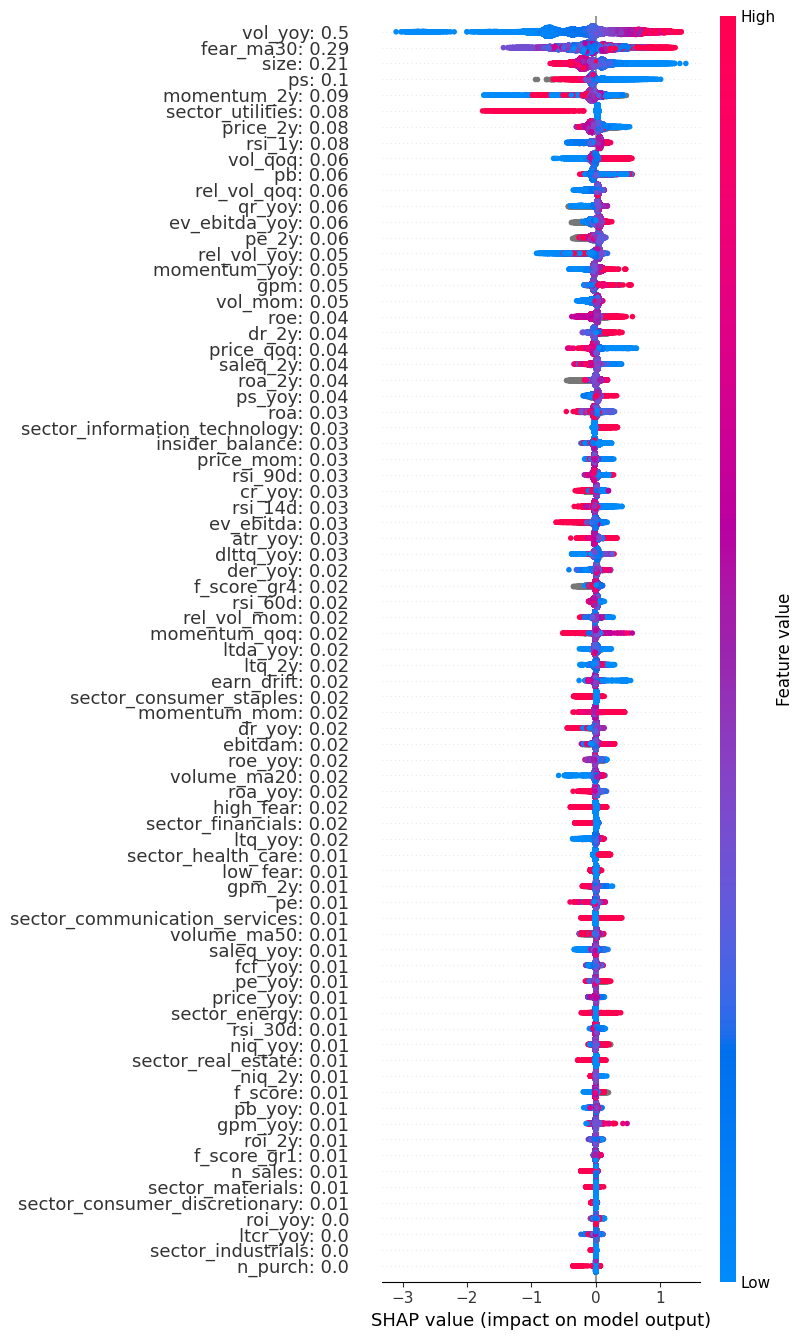

In [23]:
import numpy as np
import shap

explainer = shap.TreeExplainer(model.model)
shap_values = explainer(X_train)

feature_names = [
    a + ": " + str(b)
    for a, b in zip(X_train.columns, np.abs(shap_values.values).mean(0).round(2), strict=False)
]

shap.summary_plot(
    shap_values,
    X_train,
    max_display=X_train.shape[1],
    feature_names=feature_names,
    plot_size=(8, 13.5),
)